In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import date
import time
import matplotlib as mlt
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ridge_regression

import warnings
warnings.filterwarnings("ignore")

In [2]:
# RANDOM_SEED = 42

In [3]:
# '''Опишем класс с Label и OneHot encodings'''
# class Encoder():
#     def __init__(self, dataframe):
#         self.dataframe = dataframe

#     def label_encoder(self, column):
#         '''Method is called for label encoding'''
#         le = LabelEncoder()
#         self.dataframe[column] = le.fit_transform(self.dataframe[column])

#     def hot_encoder(self, column):
#         '''Method is calling for hot encoding'''
#         ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
#         aux_df = pd.DataFrame(ohe.fit_transform(self.dataframe[[column]]))
#         aux_df.columns = ohe.get_feature_names([f'hot_{column}'])
#         self.dataframe = self.dataframe.drop(col, axis=1)
#         self.dataframe = pd.concat([self.dataframe, aux_df], axis=1)
#         return self.dataframe

In [4]:
df = pd.read_csv('data.csv',sep=';')

In [5]:
df.columns = ['date', 'value']

In [6]:
df.isna().sum()

date     0
value    0
dtype: int64

Пропусков нет

In [7]:
df['date'] = df.date.apply(lambda x:pd.Timestamp(x)) # Переведем в Timestamp


<AxesSubplot:xlabel='date', ylabel='value'>

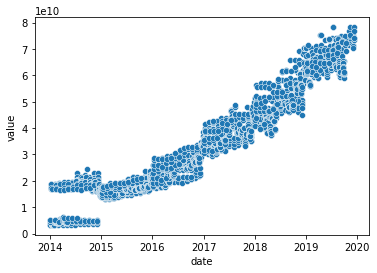

In [8]:
sns.scatterplot(x='date', y='value', data=df)

# Таргет

Для работы с временным рядом, нам нужно проверить стационарный ли он.

Text(0.5, 1.0, 'График изменения резерва')

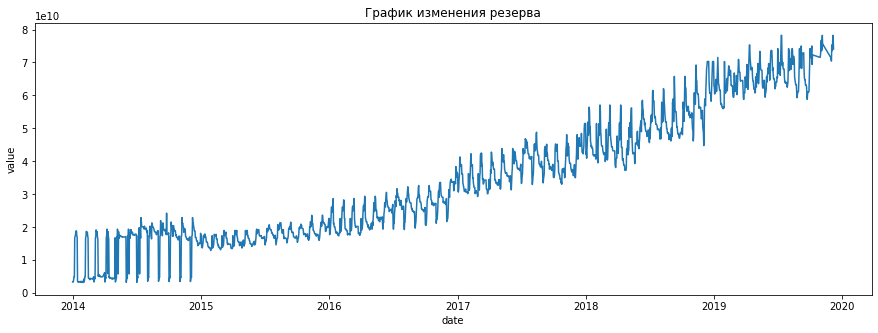

In [9]:
plt.figure(figsize=(15, 5))
sns.lineplot(df['date'], df['value'])
plt.title('График изменения резерва')

In [10]:
print("p-value:", adfuller(df['value'])[1])

p-value: 0.9349887607019661


Видим, что временной ряд гетероскедастичен(неодинаковая дисперсия значений) и нестационарен (явно выражен тренд, проглядывается сезонность размером в год) и p-value 0.95, что больше уровня значимости 0.05.


## Бокс- Кокс

In [11]:
df['box_cox'] = stats.boxcox(df['value'])[0]

Text(0.5, 1.0, 'График изменения резерва после преобразования Бокса - Кокса')

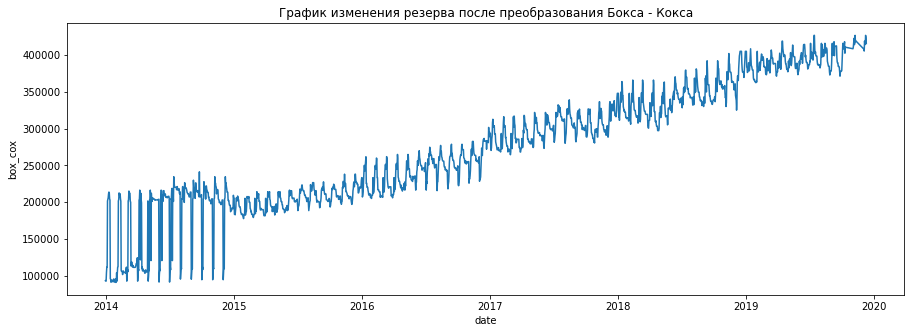

In [12]:
plt.figure(figsize=(15, 5))
sns.lineplot(df['date'], df['box_cox'])
plt.title('График изменения резерва после преобразования Бокса - Кокса')

In [13]:
print("p-value:", adfuller((df['box_cox']))[1])

p-value: 0.3395365797837589


После преобразования Бокса- Кокса, график стал выглядеть лучше. Тренд заметен, но гетероскедастичность не выражена.
По критерию Фюллера, ряд нестационарен

In [14]:
df['value_log'] = np.log(df['value'])

Text(0.5, 1.0, 'Прологарифмированный график изменения резерва')

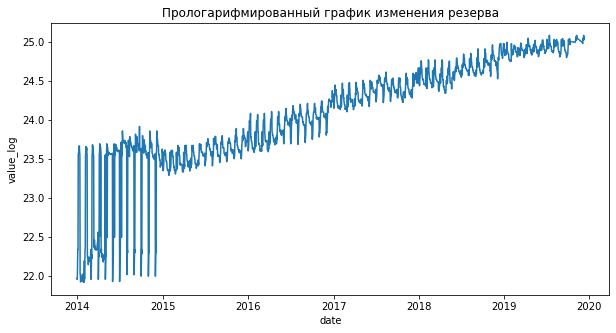

In [15]:
plt.figure(figsize=(10, 5))
sns.lineplot(df['date'], df['value_log'])
plt.title('Прологарифмированный график изменения резерва')

In [16]:
print("p-value:", adfuller(df['value_log'])[1])

p-value: 0.01596350325953934


При помощи логарифмироания, удалось избавиться от гетерокседантичности, и p-value стал меньше 0.05. но все еще видим тренд .

# Дифференцирование

In [17]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

Text(0.5, 1.0, 'Дифференцированный график изменения резерва')

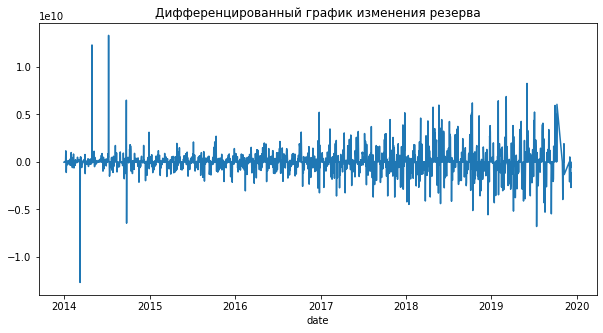

In [18]:

plt.figure(figsize=(10, 5))
sns.lineplot(df['date'], difference(df['value']))
plt.title('Дифференцированный график изменения резерва')

Text(0.5, 1.0, 'Дифференцированный график изменения резерва после Бокса- Кокса')

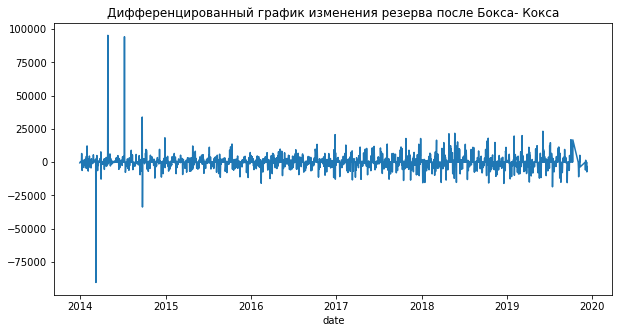

In [19]:
plt.figure(figsize=(10, 5))
sns.lineplot(df['date'], difference(df['box_cox']))
plt.title('Дифференцированный график изменения резерва после Бокса- Кокса')

Text(0.5, 1.0, 'Прологарифмированный дифференцированный график изменения резерва')

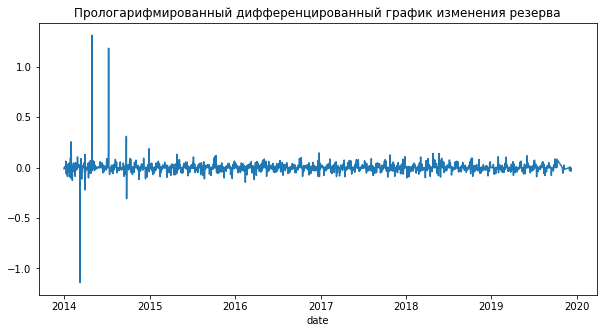

In [20]:
plt.figure(figsize=(10, 5))
sns.lineplot(df['date'], difference(df['value_log']))
plt.title('Прологарифмированный дифференцированный график изменения резерва')

Дифференцирование прологарифмированного ряда избавило его от тренда. Используем это при подборе параметров ARIMA

In [21]:
df['value_log_dif'] = difference(df['value_log'])

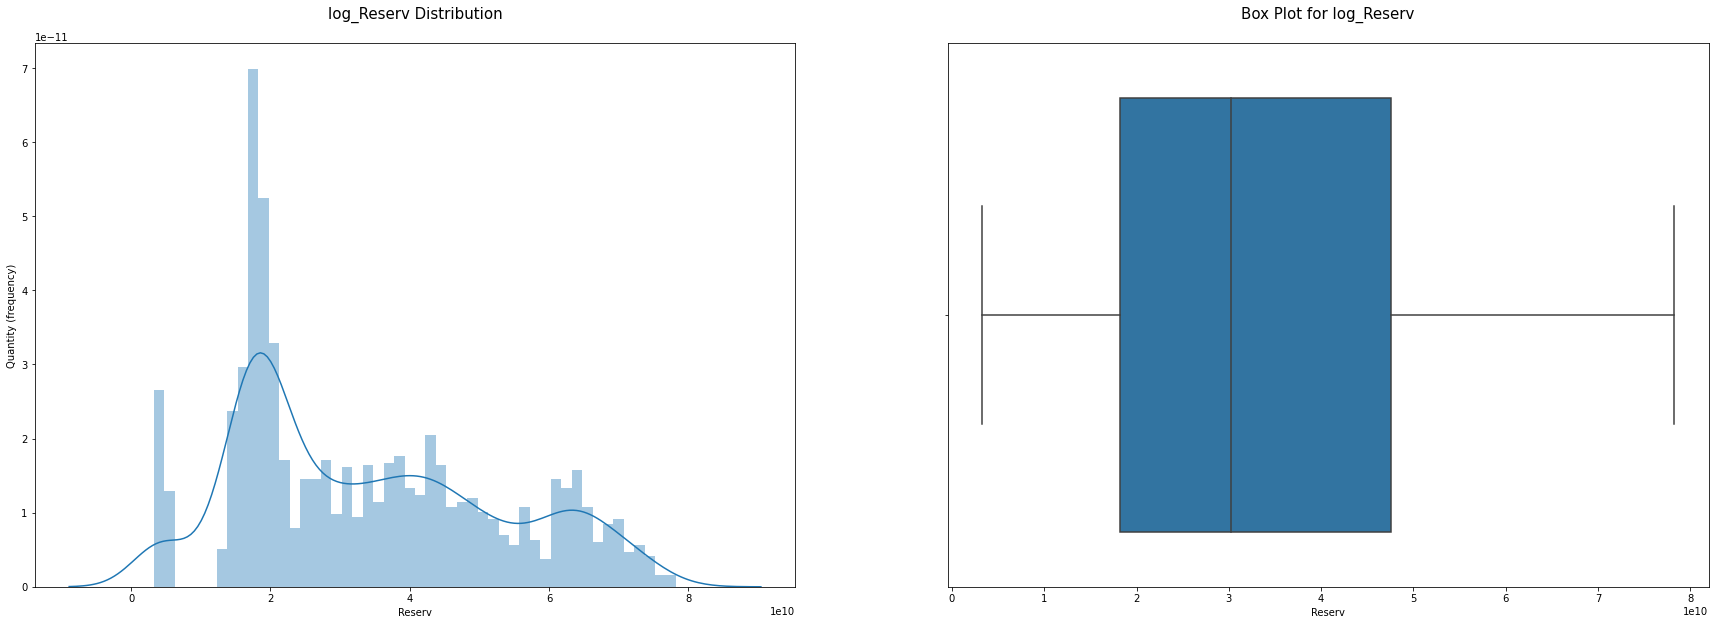

In [22]:
plt.figure(figsize=(30,10))
plt.subplot(121)
sns.distplot(df['value'].values , bins=50)
plt.title('log_Reserv Distribution\n', fontsize=15)
plt.xlabel('Reserv')
plt.ylabel('Quantity (frequency)');

plt.subplot(122)
sns.boxplot(df['value'] .values )
plt.title('Box Plot for log_Reserv\n', fontsize=15)
plt.xlabel('Reserv');



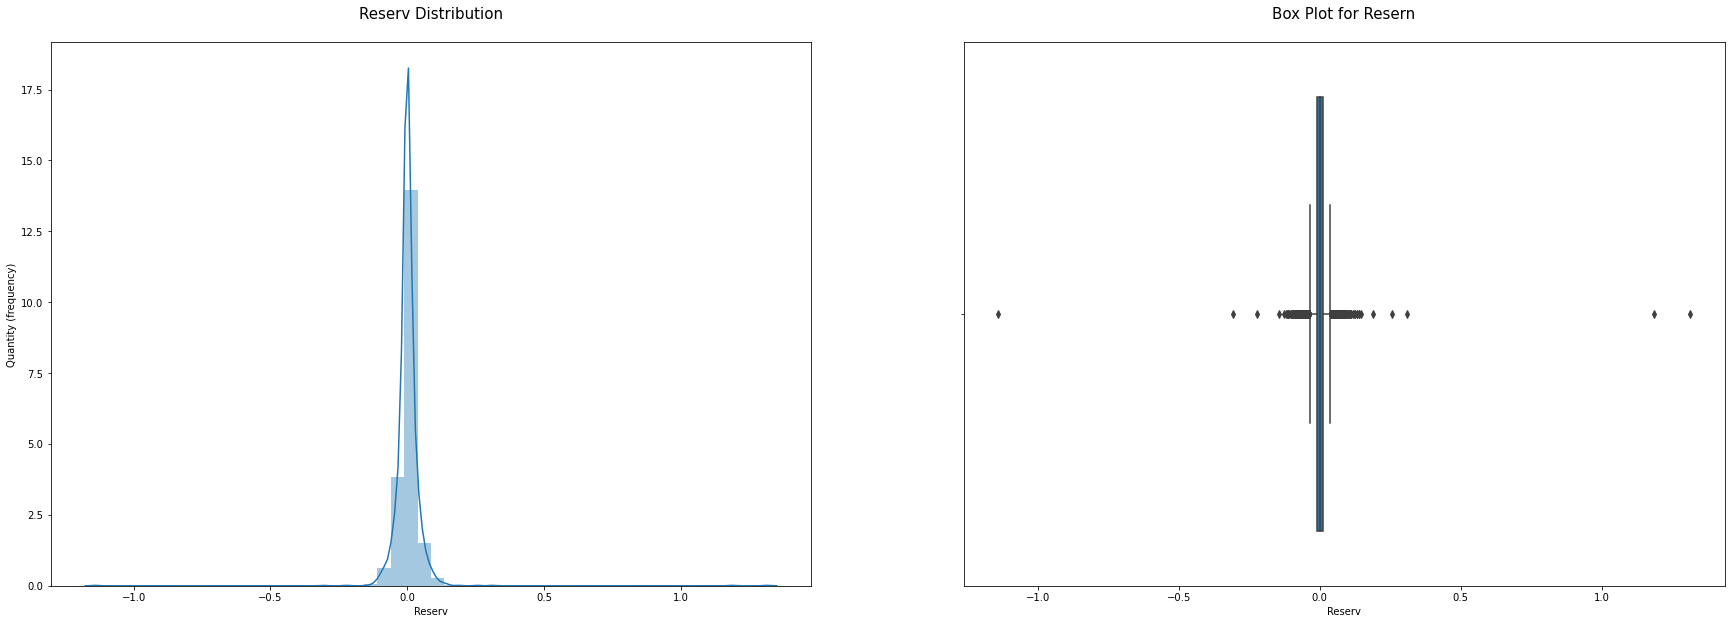

In [23]:
plt.figure(figsize=(30, 10))
plt.subplot(121)
sns.distplot(difference(df['value_log']).values, bins=50)
plt.title('Reserv Distribution\n', fontsize=15)
plt.xlabel('Reserv')
plt.ylabel('Quantity (frequency)');

plt.subplot(122)
sns.boxplot(difference(df['value_log']) .values)
plt.title('Box Plot for Resern\n', fontsize=15)
plt.xlabel('Reserv');



# Решение "В лоб"

## Для прогнозирования воспользуемся моделью ARIMA

In [24]:
timeseries = df['value']

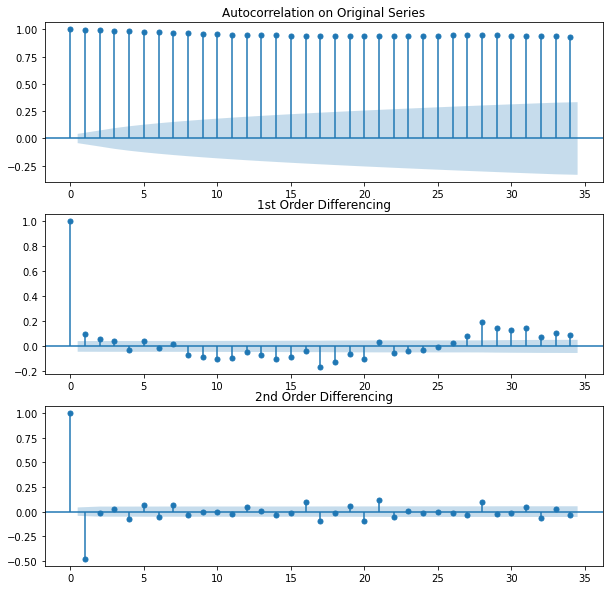

In [25]:

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

In [26]:
timeseries_log = df['value_log']


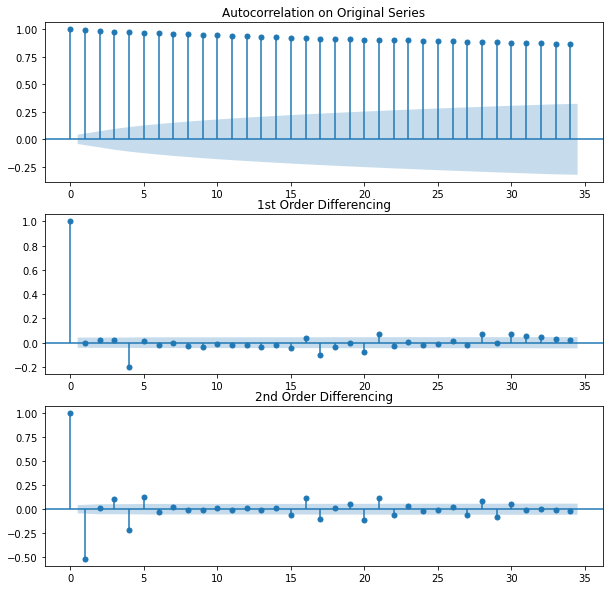

In [27]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries_log, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries_log.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries_log.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

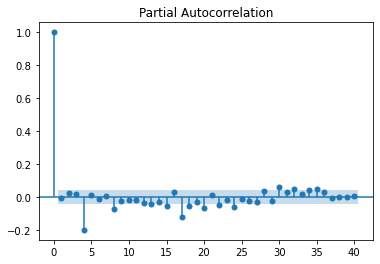

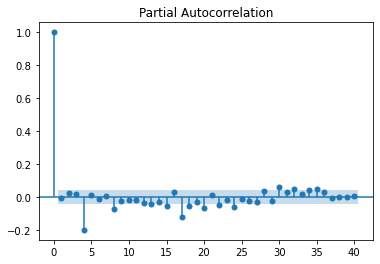

In [28]:
plot_pacf(timeseries_log.diff().dropna(), lags=40)

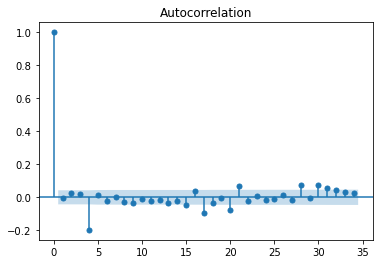

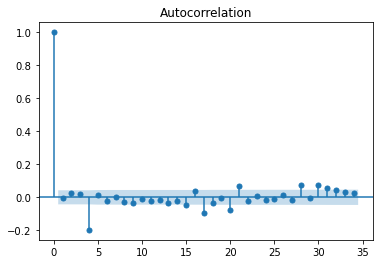

In [29]:
plot_acf(timeseries_log.diff().dropna())

In [30]:
month = 30 # Предположим, что в месяце в среденм 30 дней
lastday_reserv = df['value'].iloc[-1] # Последнее истинное значение резерва

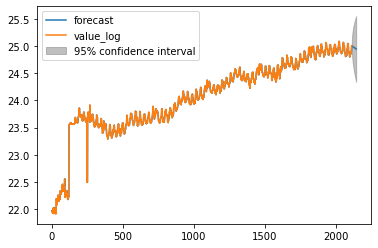

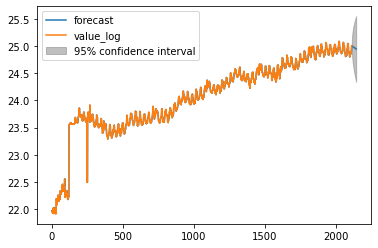

In [31]:

model = ARIMA(timeseries_log, order=(1, 0, 1))
results = model.fit()
results.plot_predict(1, len(df) + month )


In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              value_log   No. Observations:                 2111
Model:                     ARMA(1, 1)   Log Likelihood                3062.383
Method:                       css-mle   S.D. of innovations              0.057
Date:                Sat, 04 Sep 2021   AIC                          -6116.766
Time:                        00:55:06   BIC                          -6094.146
Sample:                             0   HQIC                         -6108.483
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              23.8565      0.576     41.428      0.000      22.728      24.985
ar.L1.value_log     0.9982      0.001    683.705      0.000       0.995       1.001
ma.L1.value_log    -0.0005      0.021     -0.022      0.982      -0.042       0.041
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0018           +0.0000j            1.0018            0.0000
MA.1         2137.0348           +0.0000j         2137.0348            0.0000
-----------------------------------------------------------------------------
"""

# Подберем параметры с auto_arima

In [33]:
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel

In [34]:
def plotarima(n_periods, timeseries, automodel):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, 
                                    return_conf_int=True)
    # Daily index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=n_periods, freq="D")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)    # Create plot
    plt.figure(figsize=(20, 6))
    plt.plot(timeseries)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.25)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper right")
    plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6111.352, Time=1.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19422.184, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.94 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=2.58 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-6110.269, Time=2.21 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.92 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.48 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=3.44 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6111.945, Time=1.00 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1642.948, Time=0.53 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6119.378, Time=3.32 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-6128.091, Time=5.68 sec
 

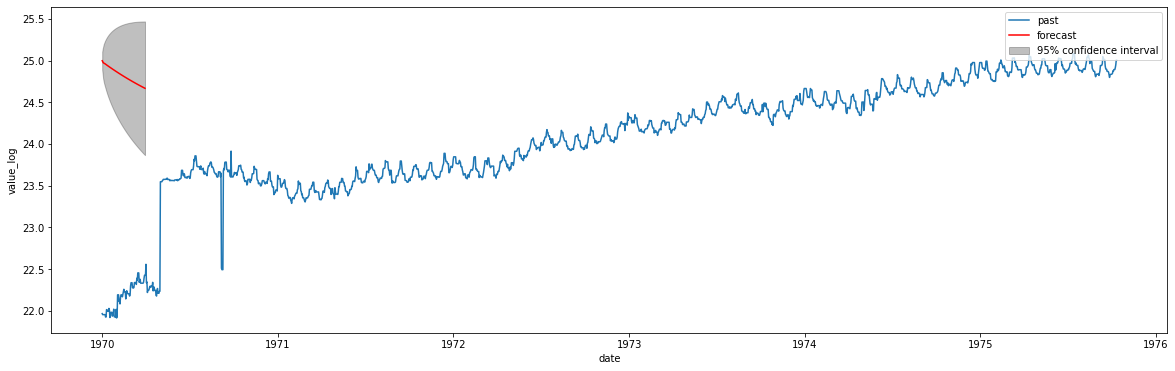

In [35]:
automodel = arimamodel((df['value_log']))
plotarima(90, df['value_log'], automodel)

Оптимальные параметры (5, 0, 1)

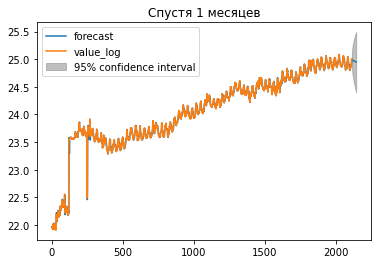

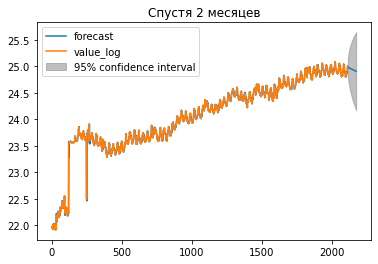

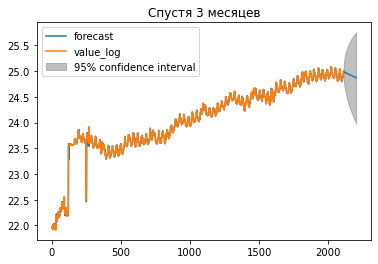

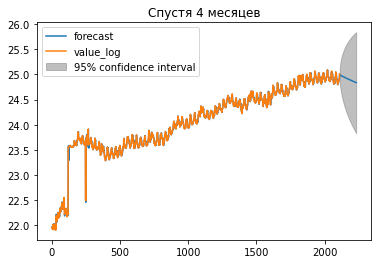

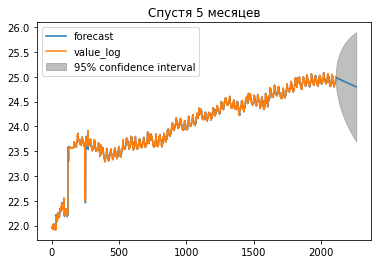

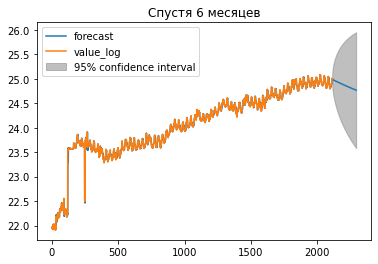

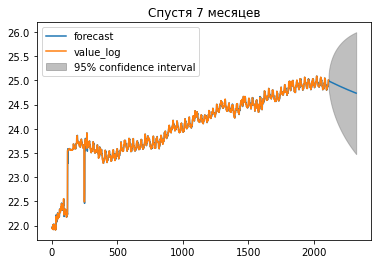

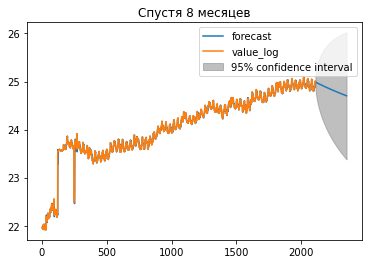

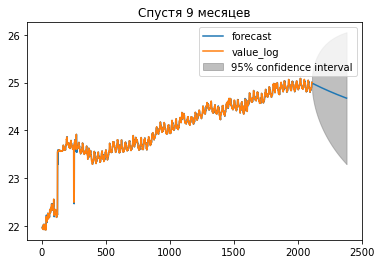

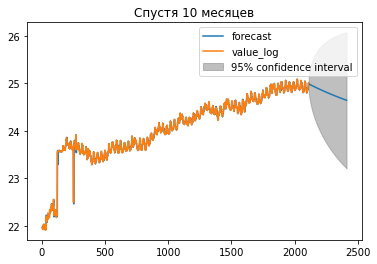

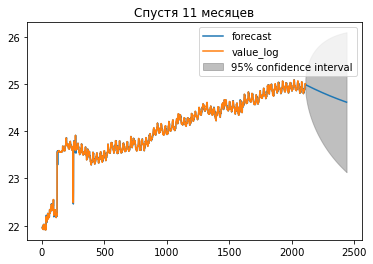

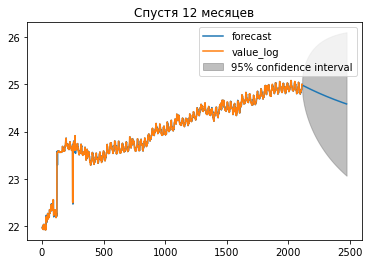

In [49]:
model = ARIMA(timeseries_log, order=(5, 0, 1))
results = model.fit()

for num in range(1, 13):
    results.plot_predict(1, len(df) + month * num)
    plt.title(f'Спустя {num} месяцев')

Text(0.5, 1.0, 'График предсказания изменения резерва за год')

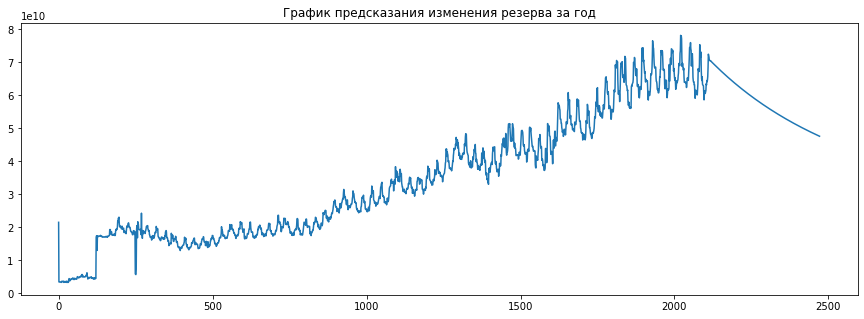

In [37]:
plt.figure(figsize=(15,5))
pd.Series(np.exp(results.predict(0, len(df) + month * 12))).plot()
plt.title('График предсказания изменения резерва за год')

In [38]:
forecasted = pd.Series(np.exp(results.predict(0, len(df) + month * 12)))

In [39]:
# Для наглядности поместим максимальные объемы пробития стабильности в список
forcast_per_month = [forecasted[len(df) + month*x] for x in range(1, 13)] 


In [40]:
forcast_per_month

[68305858064.40904,
 65717539233.08665,
 63309074616.68514,
 61065113313.750626,
 58971849244.81008,
 57016841952.70036,
 55188862987.21632,
 53477761472.25425,
 51874346239.35557,
 50370282296.582115,
 48957999726.10217,
 47630613377.86379]

In [41]:
reserv_year_ago =  list(np.exp(results.predict(0, len(df) + month * 12)))[-1]

In [42]:
print(f'Судя по предсказанию значений временного ряда, за год резерв уменьшится на: {lastday_reserv - reserv_year_ago}')

Судя по предсказанию значений временного ряда, за год резерв уменьшится на: 24677247473.136208


# Попытки решить задачу квантильной регрессией

In [43]:
# df['quarter'] = df.date.apply(lambda x: x.quarter)
# df['day'] = df.date.apply(lambda x: x.day)
# df['week'] = df.date.apply(lambda x: x.week)
# df['is_month_start'] = df.date.apply(lambda x: x.is_month_start)
# df['is_month_end'] = df.date.apply(lambda x: x.is_month_end)
# df['is_leap_year'] = df.date.apply(lambda x: x.is_leap_year)


# encoder = Encoder(df)

# cols_to_label = ['is_month_start', 'is_month_start', 'is_month_end', 'is_leap_year']
# cols_to_hot = ['quarter', 'day', 'week']

# for col in cols_to_label:    
#     encoder.label_encoder(col)
    
# for col in cols_to_hot:
#     df = encoder.hot_encoder(col)


# df = df.drop([ 'unixtime'], axis=1)

In [44]:
# train = df.iloc[:round(len(df) * 0.8)] # Берем первые 80 процентов датасета для обучения
# forecast = df.iloc[round(len(df) * 0.8)+1:] # Берем оставшиеся 20 процентов для проверки прогноза
# X = train.drop(['value','date'], axis=1) # Признаки для обучения
# y = train['value'] # Таргет


# X_val = forecast.drop('value', axis=1) 
# y_val = forecast['value'] # Истинные значения

In [45]:
# X_train, X_test,y_train , y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=RANDOM_SEED)